# GPTChallenge: diagnóstico a partir de HCE

**Grupo 2: GPTSovereigns** 👨‍💻

Integrantes: 
- Martínez Leal, Jesús
- Ortega Mediavilla, Samuel
- Vicente Martínez, Pablo

**OBJETIVO**. Clasificar texto procedente de historias clínicas electrónicas en código CIE-10 usando ChatGPT.

El CIE-10 (Clasificación Internacional de Enfermedades, décima edición) es un sistema de clasificación médica utilizado para codificar y clasificar enfermedades y otros problemas de salud. ASigna códigos alfanuméricos a una amplia variedad de enfermedades, trastornos, lesiones, causas externas de morbilidad y otros problemas de salud. Cada código está compuesto por entre 3 y 7 caracteres, que proporcionan información detallada sobre la condición médica o el evento en cuestión.

Tendremos un **conjunto de train** con historias clínicas electrónicas y varias etiquetas CIE-10 asociadas, así como un **conjunto de test** *no etiquetado*. El resultado de la predicción solo podrá ser visto al subirlo a una página web que nos brindaron los profesores, disponiendo de un máximo de **3 intentos**. Para ello, previamente deberemos guardar las predicciones sobre este conjunto en un **dataframe** que exportaremos a formato `.csv`.

Será necesario que demos también nuestro historial de chat en ChatGPT (uno por integrante) en lo relacionado con el proyecto, por lo que será necesario dar el enlace directo de este (al final del notebook está).

Por último, se deberá escribir un artículo científico con las secciones siguientes: 1. Introducción, 2. Materiales y métodos, 3. Resultados, 4. Discusión y 5. Conclusiones.

Aunque el dataset de **train** tiene casi 1000 códigos, tomaremos solo las historias clínicas con los **10 códigos más frecuentes**.

==============================================================================================================================================================================================================================================================================================

En este notebook haremos uso de los textos en inglés para ver cómo funcionan modelos preentrenados como BERT (o variantes).

## Carga de librerías y definición de funciones 

In [2]:
import matplotlib.pyplot as plt # used for plotting
import seaborn as sns # used for plotting more
import pandas as pd
import os, re
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer, AutoModel 
from torch import no_grad
from sklearn.metrics import classification_report, make_scorer, precision_recall_fscore_support # used for evaluation
from transformers import BartTokenizer, BartModel
pd.options.display.max_colwidth = None

In [77]:
def addScoresEN(scoresDf, modelName, precision, recall, f1_score, support, vectorizerName):
    idx = np.where((scoresDf['model'] == modelName) & (scoresDf['vectorizer'] == vectorizerName))[0]
    if idx.size == 0:
        idx = scoresDf.shape[0]
    elif idx.size > 1:
        raise Exception('Hay filas duplicadas en la tabla de scores.')
    else:
        idx = idx[0]
    
    scoresDf.loc[idx] = {'model': modelName, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'support': support, 'vectorizer': vectorizerName}

    return scoresDf

## Lectura y preprocesamiento de los datos

### Conjunto de train

In [78]:
#los códigos están en un TSV con un código por línea
train_diag = pd.read_csv("data/train/train.tsv", sep="\t", header=None, names=["archivo", "codigo"])
train_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8316 entries, 0 to 8315
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  8316 non-null   object
 1   codigo   8316 non-null   object
dtypes: object(2)
memory usage: 130.1+ KB


In [79]:
train_diag['codigo'].value_counts()

codigo
r52        163
r69        150
r50.9      142
i10        116
r59.9       95
          ... 
d37.030      1
c79.71       1
g25.0        1
l76.3        1
n81.2        1
Name: count, Length: 2194, dtype: int64

In [80]:
#cogemos la categoría superior de cada código y las agrupamos
train_diag['cat'] = train_diag['codigo'].str.extract(r'(\w\d\d)')
print(train_diag['cat'].value_counts())
train_diag['cat'].nunique()

cat
r52    163
r10    163
r59    160
r69    150
r50    144
      ... 
c31      1
d62      1
s53      1
s34      1
n81      1
Name: count, Length: 918, dtype: int64


918

In [81]:
categories=train_diag['cat'].value_counts()[:10]
top_categorias = categories.index.to_list()
print(top_categorias)

['r52', 'r10', 'r59', 'r69', 'r50', 'r60', 'i10', 'r11', 'n28', 'd49']


In [82]:
type(train_diag['cat'])

pandas.core.series.Series

In [83]:
#seleccionamos sólo las etiquetas de este subconjunto
train_diag = train_diag[np.isin(train_diag['cat'], top_categorias)]

In [84]:
#cargamos los dos conjuntos de train
path = 'data/train/text_files_en/'

corpus = []
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    with open(os.path.join(path, f), encoding="utf8") as text:
        texto = text.read()
    #buscamos códigos
    file = f[:-4]
    codigos = train_diag.query('archivo==@file')['cat'].to_list()
    codigos = list(set(codigos))
    if codigos:
        corpus.append({
            'archivo': file,
            'texto': texto,
            'codigos': codigos
        })
    
df_train = pd.DataFrame(corpus).set_index('archivo')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, S0004-06142005000700014-1 to S2340-98942015000100005-1
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   texto    562 non-null    object
 1   codigos  562 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


In [85]:
df_train.sample(1)

,texto,codigos
archivo,,
S0212-71992000001200009-1,"A 61-year-old Caucasian woman was diagnosed 13 years earlier with IPF by transbronchial lung biopsy.\nThe patient had been treated with corticosteroids up to two years before.\nShe had received continuous home therapy for 20 months.\nSix years before she had been diagnosed with duodenal ulcer and had no other relevant history.\nIn the week prior to admission she had frequent and severe cough attacks, without expectoration, fever or increase in her habitual dyspnea.\nOn the day of admission she came to the emergency department with sudden swelling in the left cervical region, intermittent midthoracic pain, which increased with cough and respiratory movements, and dyspnea.\nPhysical examination revealed tachypnea (32 breaths/minute), tachycardia (120 beats/minute), swelling and crepitation in the left cervical region, both auscultatory fields fine.\nThe most relevant analytical data were: leukocytes 23.9x109/l (80% neutrophils), hemoglobin 132 g/l, hematocrit 39.4%, LDH 342 U/l and creatine kinase 123 U/l.\nBasal arterial gas values were: pH 7.47, PO2 54 torr, PCO2 36 torr, HCO3- 27.1 / l and oxygen saturation 90%.\nThe electrocardiogram showed sinus rhythm at 120 beats per minute, the rest of the tracing being normal.\nA neck X-ray showed a predominantly left cervical emphysema.\nA chest X-ray showed a pattern of bilateral pulmonary fibrosis more pronounced in the lower lung areas, with evidence of anterior pneumomediastinum in the lateral lung.\nA computed tomography (CT) scan of the chest revealed a marked pattern of bilateral pulmonary fibrosis, pneumomediastinum and large air bubbles in the left upper lobe, with no evidence of pneumothorax.\n1.\nThe evolution was favorable with symptomatic treatment, disappearing after 14 days in controls subcutaneous emphysema and pneumomediastinum.\n",[r50]


## Cargar los textos del conjunto de test

In [86]:
#los códigos están en un TSV con un código por línea
test_diag = pd.read_csv("data/test/test.tsv", sep="\t", header=None, names=["archivo"])
test_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  192 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


In [87]:
path = 'data/test/text_files_en/'

corpus = []
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    if os.path.splitext(f)[0] in test_diag['archivo'].values:
        with open(os.path.join(path, f), encoding="utf8") as text:
            texto = text.read()
            corpus.append({
                'archivo': file,
                'texto': texto
            })
    
df_test = pd.DataFrame(corpus).set_index('archivo')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, S2340-98942015000100005-1 to S2340-98942015000100005-1
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   192 non-null    object
dtypes: object(1)
memory usage: 3.0+ KB


In [88]:
df_test.sample(1)

,texto
archivo,
S2340-98942015000100005-1,"A 38-year-old male, with no relevant urological history, presented with a mass in the left side of the neck that had evolved for seven months, which was slow, progressive and painless.\nPhysical examination revealed a soft mass of about 3 cm, not painful to palpation or adhered to adjacent structures, with negative transition and normal testicles.\nWith negative testicular markers, an ultrasound was performed, which was reported as a lesion for homogeneous paraformicular and with regular borders of about 2 cm due to tape measure.\n1.\nIn view of the diagnostic doubts, a surgical exploration was carried out, which revealed a presence of approximately 2 x 1.5 cm in the resected cord, which was easily removed, had a soft consistency and was easy to resect.\nA left inguinal excision of the mass was performed, removing it from the cord.\nSubsequently, the pathological study showed the presence of a well-differentiated LPS subtype like.\nIt was decided not to complete the surgery with orchiectomy due to the small size of the tumor and its lower grade staging associated with a good prognosis.\nTwenty-six months after surgery the patient is asymptomatic and without evidence of tumor recurrence.\n"


## Binarizar las etiquetas

In [89]:
# para entrenar un clasificador multi-etiqueta generamos una matriz binaria de las etiquetas
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['codigos'])

#Guardamos las clases utilizadas en el conjunto de train
clases = mlb.classes_
num_classes = clases.shape
print(num_classes[0])

10


## Procesamiento del lenguaje natural

Probamos distintos modelos de Transformers para ver qué resultados obtenemos en esta versión inglesa.

## Modelos

In [3]:
scoresDfPath = 'results/scoresEN.csv'
if os.path.isfile(scoresDfPath):
    scoresDfEN = pd.read_csv(scoresDfPath, header = 0)
else:
    scoresDfEN = pd.DataFrame(columns = ['model', 'precision', 'recall', 'f1_score', 'support', 'vectorizer'])

scoresDfEN.head()

,model,precision,recall,f1_score,support,vectorizer
0,MLP,0.426456,0.363309,0.383427,NaN,medBERT
1,MultiOutput-AdaBoost-GBoost,0.473732,0.115108,0.172492,NaN,medBERT
2,MLP,0.323325,0.273381,0.292074,NaN,BERT-base-uncased
3,MultiOutput-AdaBoost-GBoost,0.254845,0.064748,0.100221,NaN,BERT-base-uncased
4,MLP,0.350750,0.302158,0.315664,NaN,bart-large


### medBERT

In [91]:
fileNameMED = 'data/data_with_med_embeddings_en.tsv'
vectorizerName = 'medBERT'

In [92]:
if not os.path.isfile(fileNameMED):
    
    tokenizer = AutoTokenizer.from_pretrained("Charangan/MedBERT")
    model = AutoModel.from_pretrained("Charangan/MedBERT")

    # Function to tokenize and obtain embeddings
    def get_bert_embeddings(text):
        # Tokenize text
        tokens = tokenizer(text, return_tensors='pt', padding = True, truncation = True, max_length = 100, add_special_tokens = False)
        # Get BERT model output
        with no_grad():
            output = model(**tokens)
        # Extract embeddings for [CLS] token
        embeddings = output.last_hidden_state[:,0,:].squeeze(0).numpy()
        return embeddings

    # Assuming 'df' is your DataFrame and 'text_column' is the name of the column containing the text
    df_train['embedding'] = df_train['texto'].apply(lambda x: get_bert_embeddings(x))

    # Save the DataFrame with the embeddings column
    df_train.to_csv(fileNameMED, index=False, sep = "\t")
else:
    df_train = pd.read_csv(fileNameMED, index_col=False, sep = "\t")
    df_train['codigos'] = df_train['codigos'].apply(lambda s: eval(s))

    def insert_space_before_negative(string):
        return re.sub(r'(\s-)', r' \1', string)

    df_train["embedding"] = df_train["embedding"].apply(lambda x: insert_space_before_negative(x))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace("\n", ""))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace("  ", ", "))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace(", , ", ", "))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: eval(s))

In [93]:
X = [list(x) for x in df_train['embedding'].values]

# Binarizar
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['codigos'])

# Guardamos las clases utilizadas en el conjunto de train
clases = mlb.classes_
num_classes = clases.shape
print(num_classes[0])

10


In [94]:
x_train, x_test, y_train_train, y_train_test = train_test_split(X, y_train, random_state = 3)

In [95]:
modelName = 'MLP'

multi_target_classifier = MLPClassifier(activation = 'tanh', solver = 'adam', max_iter = 5000, n_iter_no_change = np.inf, random_state = 3, verbose = 1)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

precision, recall, f1_score, support = precision_recall_fscore_support(y_train_test, y_pred, average = 'weighted')
scoresDfEN = addScoresEN(scoresDfEN, modelName, precision, recall, f1_score, support, vectorizerName)

Iteration 1, loss = 7.12362547
Iteration 2, loss = 5.07473520
Iteration 3, loss = 4.96046949
Iteration 4, loss = 4.95446883
Iteration 5, loss = 4.83642524
Iteration 6, loss = 4.67613759
Iteration 7, loss = 4.50482763
Iteration 8, loss = 4.36820224
Iteration 9, loss = 4.25609505
Iteration 10, loss = 4.18237970
Iteration 11, loss = 4.12662643
Iteration 12, loss = 4.05373709
Iteration 13, loss = 3.97593527
Iteration 14, loss = 3.90194051
Iteration 15, loss = 3.83637460
Iteration 16, loss = 3.76733785
Iteration 17, loss = 3.70425860
Iteration 18, loss = 3.65307817
Iteration 19, loss = 3.58700234
Iteration 20, loss = 3.52785554
Iteration 21, loss = 3.47496763
Iteration 22, loss = 3.42907173
Iteration 23, loss = 3.37871990
Iteration 24, loss = 3.32662446
Iteration 25, loss = 3.27791104
Iteration 26, loss = 3.23675284
Iteration 27, loss = 3.20485983
Iteration 28, loss = 3.16285272
Iteration 29, loss = 3.10976258
Iteration 30, loss = 3.06084801
Iteration 31, loss = 3.01743762
Iteration 32, los

c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [96]:
modelName = 'MultiOutput-AdaBoost-GBoost'

estimator = GradientBoostingClassifier(loss = 'exponential', criterion = 'friedman_mse', n_estimators = 100, max_depth = 5, min_samples_split = 5, random_state = 3)
base_classifier = AdaBoostClassifier(estimator = estimator, n_estimators = 100, random_state = 3)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

precision, recall, f1_score, support = precision_recall_fscore_support(y_train_test, y_pred, average = 'weighted')
scoresDfEN = addScoresEN(scoresDfEN, modelName, precision, recall, f1_score, support, vectorizerName)

              precision    recall  f1-score   support

           0       0.75      0.12      0.20        26
           1       0.67      0.34      0.45        35
           2       0.00      0.00      0.00        13
           3       0.71      0.17      0.28        29
           4       0.00      0.00      0.00        23
           5       0.40      0.11      0.17        36
           6       0.42      0.16      0.23        31
           7       0.17      0.04      0.06        25
           8       1.00      0.04      0.08        25
           9       0.33      0.03      0.05        35

   micro avg       0.48      0.12      0.19       278
   macro avg       0.44      0.10      0.15       278
weighted avg       0.47      0.12      0.17       278
 samples avg       0.19      0.11      0.13       278



In [97]:
print(df_train['texto'].values.shape)

(562,)


### bert-base-uncased

In [98]:
fileNamebase = 'data/data_with_base_embeddings_en.tsv'
vectorizerName = 'BERT-base-uncased'

In [99]:
if not os.path.isfile(fileNamebase):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = TFBertModel.from_pretrained("bert-base-uncased")

    # Function to tokenize and obtain embeddings
    def get_bert_embeddings(text):
        # Tokenize text
        tokens = tokenizer(text, return_tensors='tf', padding=True, truncation=True, max_length=100, add_special_tokens=False)
        # Get BERT model output
        output = model(tokens)
        # Extract embeddings for [CLS] token
        embeddings = output.last_hidden_state[:, 0, :].numpy()
        return embeddings.squeeze(0)

    # Assuming 'df_train' is your DataFrame and 'texto' is the name of the column containing the text
    df_train['embedding'] = df_train['texto'].apply(lambda x: get_bert_embeddings(x))

    # Save the DataFrame with the embeddings column
    df_train.to_csv(fileNamebase, index=False, sep="\t")
else:
    df_train = pd.read_csv(fileNamebase, index_col=False, sep="\t")
    df_train['codigos'] = df_train['codigos'].apply(lambda s: eval(s))

    def insert_space_before_negative(string):
        return re.sub(r'(\s-)', r' \1', string)

    df_train["embedding"] = df_train["embedding"].apply(lambda x: insert_space_before_negative(x))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace("\n", ""))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace("  ", ", "))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace(", , ", ", "))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: eval(s))

In [100]:
X = [list(x) for x in df_train['embedding'].values]

# Binarizar
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['codigos'])

# Guardamos las clases utilizadas en el conjunto de train
clases = mlb.classes_
num_classes = clases.shape
print(num_classes[0])

10


In [101]:
x_train, x_test, y_train_train, y_train_test = train_test_split(X, y_train, random_state = 3)

In [102]:
modelName = 'MLP'
multi_target_classifier = MLPClassifier(activation = 'tanh', solver = 'adam', max_iter = 5000, n_iter_no_change = np.inf, random_state = 3, verbose = 1)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

precision, recall, f1_score, support = precision_recall_fscore_support(y_train_test, y_pred, average = 'weighted')
scoresDfEN = addScoresEN(scoresDfEN, modelName, precision, recall, f1_score, support, vectorizerName)

Iteration 1, loss = 6.35121689
Iteration 2, loss = 4.97595051
Iteration 3, loss = 4.97419351
Iteration 4, loss = 5.00153786
Iteration 5, loss = 4.93394915
Iteration 6, loss = 4.85121814
Iteration 7, loss = 4.74637658
Iteration 8, loss = 4.64487107
Iteration 9, loss = 4.57090393
Iteration 10, loss = 4.54967693
Iteration 11, loss = 4.52862884
Iteration 12, loss = 4.47130610
Iteration 13, loss = 4.42955295
Iteration 14, loss = 4.38482360
Iteration 15, loss = 4.34498905
Iteration 16, loss = 4.29467072
Iteration 17, loss = 4.26714853
Iteration 18, loss = 4.22580162
Iteration 19, loss = 4.19261302
Iteration 20, loss = 4.14985028
Iteration 21, loss = 4.10091588
Iteration 22, loss = 4.08894472
Iteration 23, loss = 4.05748499
Iteration 24, loss = 4.01870324
Iteration 25, loss = 3.97274547
Iteration 26, loss = 3.94483647
Iteration 27, loss = 3.92667671
Iteration 28, loss = 3.91083675
Iteration 29, loss = 3.87764039
Iteration 30, loss = 3.83532059
Iteration 31, loss = 3.79852363
Iteration 32, los

c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [103]:
modelName = 'MultiOutput-AdaBoost-GBoost'
estimator = GradientBoostingClassifier(loss = 'exponential', criterion = 'friedman_mse', n_estimators = 100, max_depth = 5, min_samples_split = 5, random_state = 3)
base_classifier = AdaBoostClassifier(estimator = estimator, n_estimators = 100, random_state = 3)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

precision, recall, f1_score, support = precision_recall_fscore_support(y_train_test, y_pred, average = 'weighted')
scoresDfEN = addScoresEN(scoresDfEN, modelName, precision, recall, f1_score, support, 'BERT-base-uncased')

              precision    recall  f1-score   support

           0       0.20      0.04      0.06        26
           1       0.22      0.06      0.09        35
           2       0.33      0.15      0.21        13
           3       0.17      0.03      0.06        29
           4       0.14      0.04      0.07        23
           5       0.33      0.14      0.20        36
           6       0.08      0.03      0.05        31
           7       0.33      0.04      0.07        25
           8       0.20      0.04      0.07        25
           9       0.50      0.09      0.15        35

   micro avg       0.24      0.06      0.10       278
   macro avg       0.25      0.07      0.10       278
weighted avg       0.25      0.06      0.10       278
 samples avg       0.09      0.06      0.06       278



In [104]:
print(df_train['texto'].values.shape)

(562,)


### bart-large

In [110]:
fileNameLarge = 'data/data_with_large_embeddings_en.tsv'
vectorizerName = 'bart-large'

In [111]:
if not os.path.isfile(fileNameLarge):
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
    model = BartModel.from_pretrained("facebook/bart-large")

    # Function to tokenize and obtain embeddings
    def get_bart_embeddings(text):
        # Tokenize text
        tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=100)
        # Get BART model output
        output = model(**tokens)
        # Extract embeddings for the first token (BOS)
        embeddings = output.last_hidden_state[:, 0, :].detach().numpy()
        return embeddings.squeeze(0)

    # Assuming 'df_train' is your DataFrame and 'texto' is the name of the column containing the text
    df_train['embedding'] = df_train['texto'].apply(lambda x: get_bart_embeddings(x))

    # Save the DataFrame with the embeddings column
    df_train.to_csv(fileNameLarge, index=False, sep="\t")
else:
    df_train = pd.read_csv(fileNameLarge, index_col=False, sep="\t")
    df_train['codigos'] = df_train['codigos'].apply(lambda s: eval(s))

    def insert_space_before_negative(string):
        return re.sub(r'(\s-)', r' \1', string)

    df_train["embedding"] = df_train["embedding"].apply(lambda x: insert_space_before_negative(x))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace("\n", ""))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace("  ", ", "))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: s.replace(", , ", ", "))
    df_train["embedding"] = df_train["embedding"].apply(lambda s: eval(s))

In [112]:
X = [list(x) for x in df_train['embedding'].values]

# Binarizar
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['codigos'])

# Guardamos las clases utilizadas en el conjunto de train
clases = mlb.classes_
num_classes = clases.shape
print(num_classes[0])

10


In [113]:
x_train, x_test, y_train_train, y_train_test = train_test_split(X, y_train, random_state = 3)

In [114]:
modelName = 'MLP'
multi_target_classifier = MLPClassifier(activation = 'tanh', solver = 'adam', max_iter = 5000, n_iter_no_change = np.inf, random_state = 3, verbose = 1)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

precision, recall, f1_score, support = precision_recall_fscore_support(y_train_test, y_pred, average = 'weighted')
scoresDfEN = addScoresEN(scoresDfEN, modelName, precision, recall, f1_score, support, vectorizerName)

Iteration 1, loss = 6.57999467
Iteration 2, loss = 5.16066097
Iteration 3, loss = 5.12886896
Iteration 4, loss = 4.96732568
Iteration 5, loss = 4.88651794
Iteration 6, loss = 4.83600169
Iteration 7, loss = 4.79187498
Iteration 8, loss = 4.75456499
Iteration 9, loss = 4.72042054
Iteration 10, loss = 4.70053379
Iteration 11, loss = 4.66851436
Iteration 12, loss = 4.62767596
Iteration 13, loss = 4.60425447
Iteration 14, loss = 4.57191744
Iteration 15, loss = 4.54927525
Iteration 16, loss = 4.52398945
Iteration 17, loss = 4.46168077
Iteration 18, loss = 4.45272333
Iteration 19, loss = 4.42162629
Iteration 20, loss = 4.39533212
Iteration 21, loss = 4.38232936
Iteration 22, loss = 4.31488571
Iteration 23, loss = 4.28513569
Iteration 24, loss = 4.25769004
Iteration 25, loss = 4.21716913
Iteration 26, loss = 4.19823270
Iteration 27, loss = 4.16824628
Iteration 28, loss = 4.13588804
Iteration 29, loss = 4.09296912
Iteration 30, loss = 4.05029765
Iteration 31, loss = 4.04933953
Iteration 32, los

c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [115]:
modelName = 'MultiOutput-AdaBoost-GBoost'
estimator = GradientBoostingClassifier(loss = 'exponential', criterion = 'friedman_mse', n_estimators = 100, max_depth = 5, min_samples_split = 5, random_state = 3)
base_classifier = AdaBoostClassifier(estimator = estimator, n_estimators = 100, random_state = 3)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

precision, recall, f1_score, support = precision_recall_fscore_support(y_train_test, y_pred, average = 'weighted')
scoresDfEN = addScoresEN(scoresDfEN, modelName, precision, recall, f1_score, support, vectorizerName)

              precision    recall  f1-score   support

           0       1.00      0.12      0.21        26
           1       0.29      0.06      0.10        35
           2       0.00      0.00      0.00        13
           3       0.33      0.10      0.16        29
           4       0.00      0.00      0.00        23
           5       0.33      0.08      0.13        36
           6       0.40      0.19      0.26        31
           7       0.10      0.04      0.06        25
           8       0.25      0.04      0.07        25
           9       0.21      0.09      0.12        35

   micro avg       0.28      0.08      0.12       278
   macro avg       0.29      0.07      0.11       278
weighted avg       0.31      0.08      0.12       278
 samples avg       0.11      0.08      0.08       278



In [116]:
print(df_train['texto'].values.shape)

(562,)


## Comparación de resultados

In [4]:
scoresDfEN

,model,precision,recall,f1_score,support,vectorizer
0,MLP,0.426456,0.363309,0.383427,NaN,medBERT
1,MultiOutput-AdaBoost-GBoost,0.473732,0.115108,0.172492,NaN,medBERT
2,MLP,0.323325,0.273381,0.292074,NaN,BERT-base-uncased
3,MultiOutput-AdaBoost-GBoost,0.254845,0.064748,0.100221,NaN,BERT-base-uncased
4,MLP,0.350750,0.302158,0.315664,NaN,bart-large
5,MultiOutput-AdaBoost-GBoost,0.310492,0.079137,0.120924,NaN,bart-large


In [118]:
scoresDfEN.to_csv(scoresDfPath, index = False)

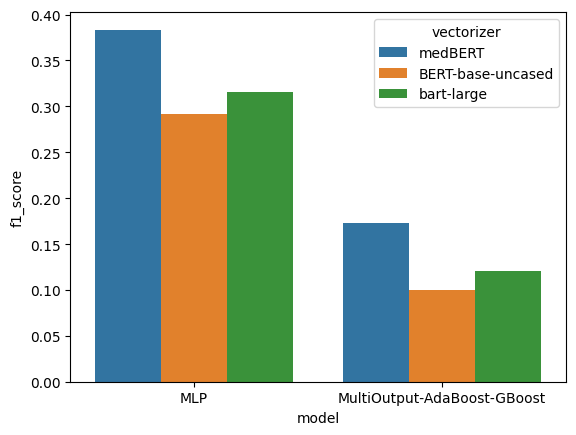

In [5]:
sns.barplot(x='model', y='f1_score', hue='vectorizer', data=scoresDfEN)

# Guardar el plot en results/images antes de mostrarlo
if not os.path.exists('./results/images'):
    os.makedirs('./results/images')

plt.savefig('./results/images/scoresDfEN_f1.png', bbox_inches='tight')

# Mostrar el plot después de guardarlo
plt.show()

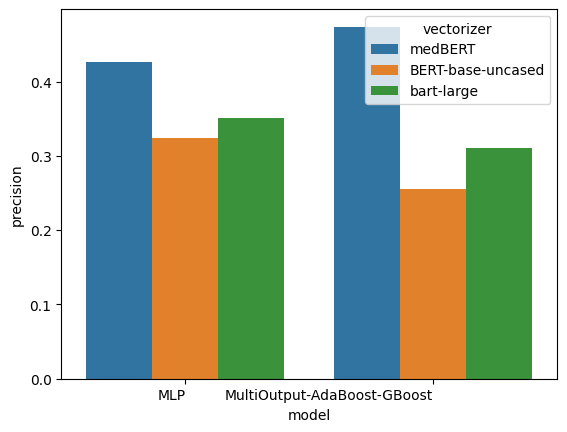

In [8]:
# Graficar también la precision

sns.barplot(x='model', y='precision', hue='vectorizer', data=scoresDfEN)
plt.xticks(rotation=0, ha='right')

# Guardar el plot en results/images antes de mostrarlo
if not os.path.exists('./results/images'):
    os.makedirs('./results/images')
    
plt.savefig('./results/images/scoresDfEN_precision.png', bbox_inches='tight')

# Mostrar el plot después de guardarlo
plt.show()

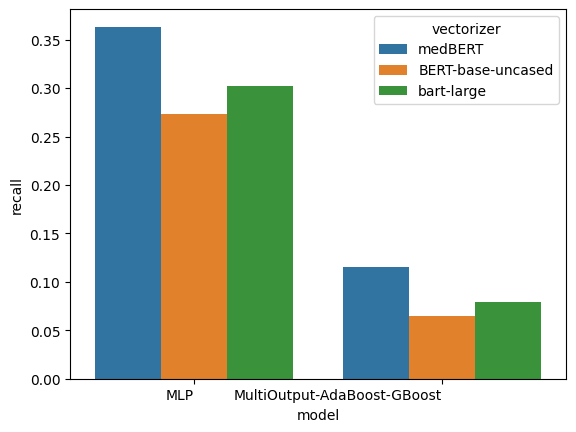

In [9]:
# Hacer con recall

sns.barplot(x='model', y='recall', hue='vectorizer', data=scoresDfEN)
plt.xticks(rotation=0, ha='right')

# Guardar el plot en results/images antes de mostrarlo
if not os.path.exists('./results/images'):
    os.makedirs('./results/images')
    
plt.savefig('./results/images/scoresDfEN_recall.png', bbox_inches='tight')

# Mostrar el plot después de guardarlo
plt.show()